In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.linear_model import LinearRegression

import copy
import seaborn as sns

In [ ]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv('SeoulBikeData.csv').drop(['Date', 'Holiday', 'Seasons'], axis=1)                        # axis=1 : drop them from the columns
df.columns = dataset_cols
df.head(5)

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [ ]:
df['functional'] = (df['functional'] == 'Yes').astype(int)
df = df[df['hour'] == 12]                                                       # only considering the noon
df = df.drop(['hour'], axis=1)
df.head(5)

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


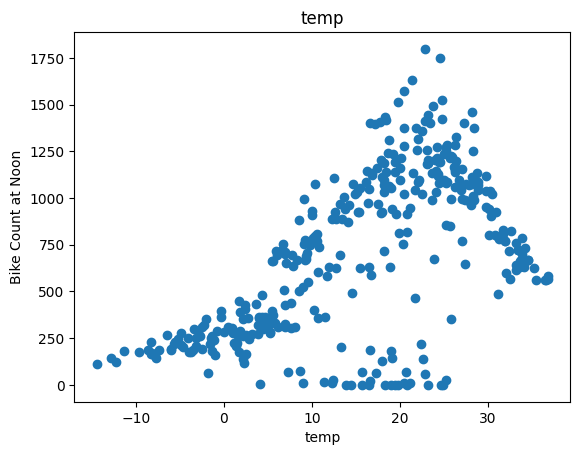

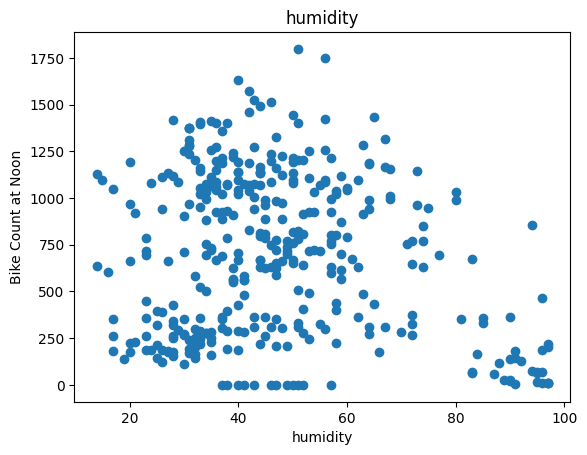

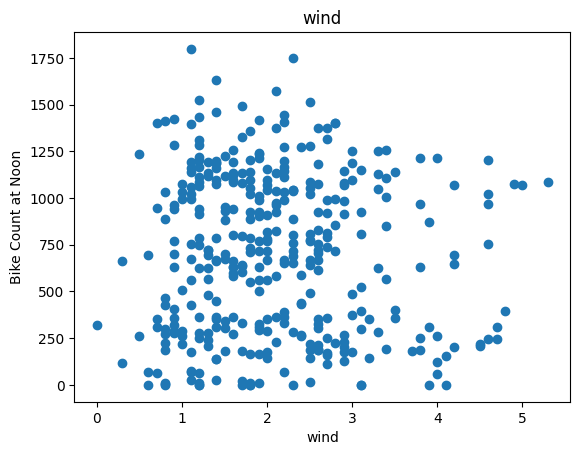

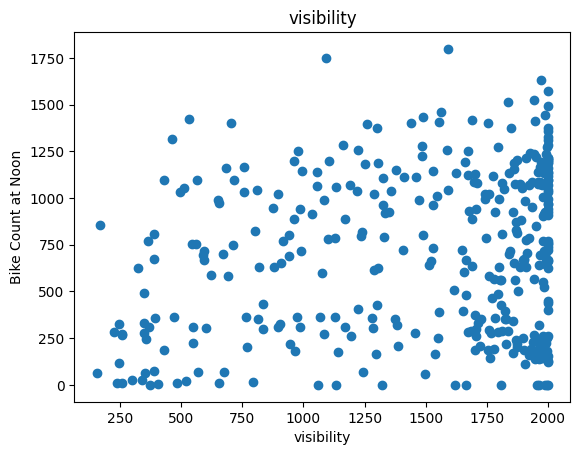

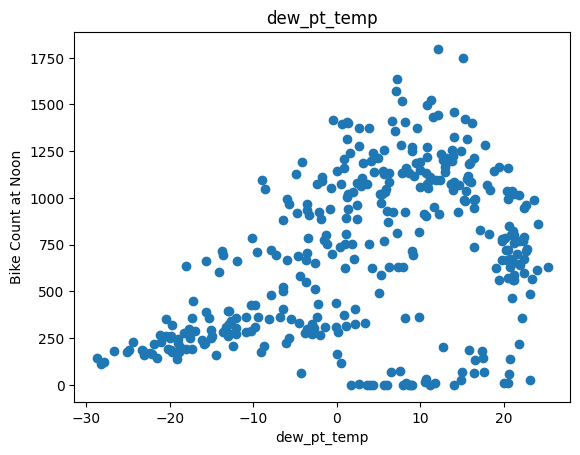

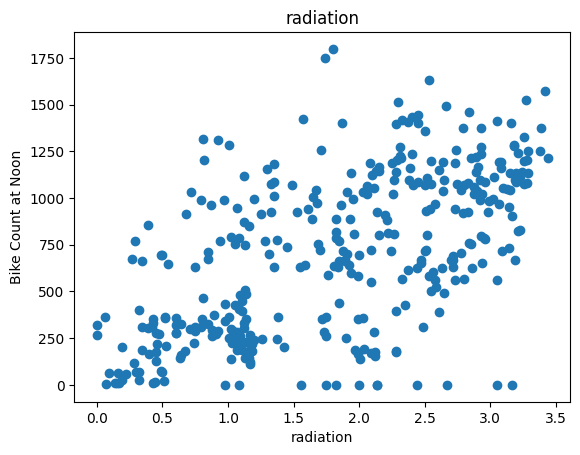

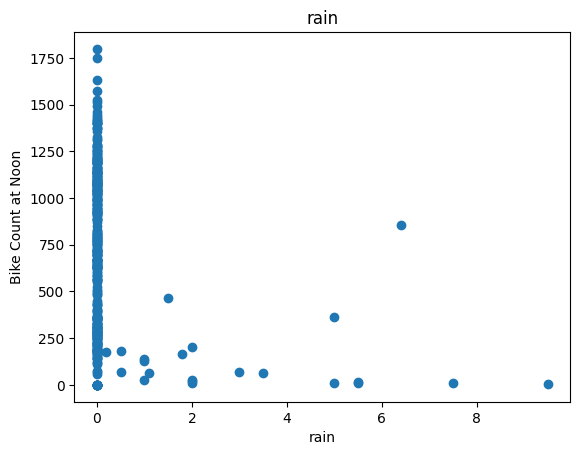

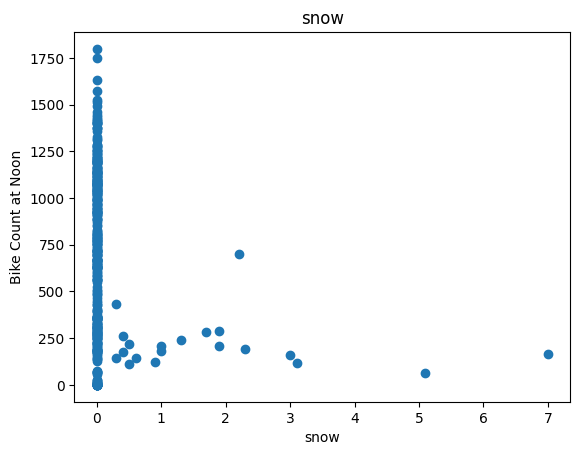

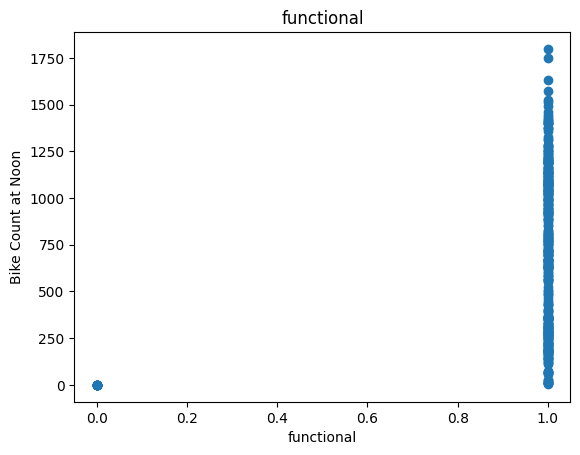

In [ ]:
for label in df.columns[1:]:                                                    # everything after the first column
  plt.scatter(df[label], df['bike_count'])
  plt.title(label)
  plt.ylabel('Bike Count at Noon')
  plt.xlabel(label)
  plt.show()


wind, visibilty and functional do not seem to be connected to the bike count -> remove

In [ ]:
df = df.drop(['wind', 'visibility', 'functional'], axis=1)

# Train/Validation/Test Dataset

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [ ]:
def get_xy(dataframe, y_label, x_labels=None):                                  # if you don't provide specific feature column names when calling the function, it will default to None
  dataframe = copy.deepcopy(dataframe)                                          # deepcopy: any modifications made to it inside the function won't affect the original df
  if x_labels is None:                                                          # checks if x_labels are provided
    X = dataframe[[col for col in dataframe.columns if col!=y_label]].values      # checks if the current column name "col" is not equal to "y_label" | formats X to numpy
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1,1)
  data = np.hstack((X,y))

  return data, X, y

In [ ]:
_, X_train_temp, y_train_temp = get_xy(train, 'bike_count', x_labels=['temp'])       # '_' : indicates that we're not interested in storing the returned train dataset
                                                                                # 'bike_count' : label of the target variable (y_label) you want to predict
                                                                                # x_labels=['temp'] : list of feature labels u want to use for prediction
_, X_val_temp, y_val_temp = get_xy(val, 'bike_count', x_labels=['temp'])
_, X_test_temp, y_test_temp = get_xy(test, 'bike_count', x_labels=['temp'])

In [ ]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)
print(temp_reg.coef_, temp_reg.intercept_)

[[20.59107951]] [386.69440635]


In [ ]:
temp_reg.score(X_test_temp, y_test_temp)                                        # R^2 score

# a higher R-squared score is typically better, indicating that the model's predictions are closer to the true values

0.18846697627098785

1st way for finding optimal linear regression:

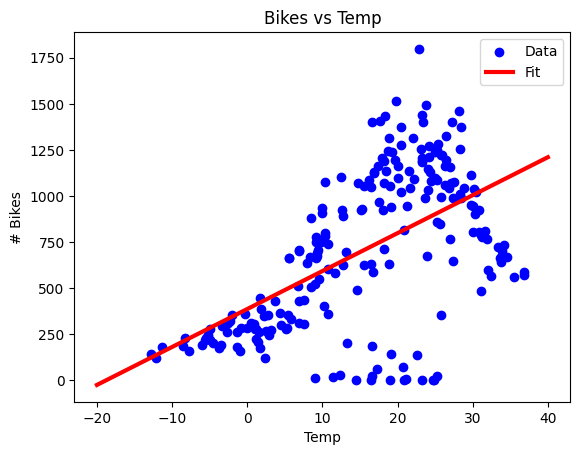

In [ ]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)                                                                         # defines x variable from -20 to 40 with 100 evenly spaced values
#plt.plot(x, temp_reg.predict(x), label='Fit', color='red', linewidt=3)                               #! systems expects a 2d array
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('# Bikes')
plt.xlabel('Temp')
plt.show()

this is what a line of best fit would look like in this case

-> !!! Assumption about linear regression may not be met

# Multiple Linear Regression

In [ ]:
df.columns

Index(['bike_count', 'temp', 'humidity', 'dew_pt_temp', 'radiation', 'rain',
       'snow'],
      dtype='object')

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, 'bike_count', x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, 'bike_count', x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, 'bike_count', x_labels=df.columns[1:])

In [ ]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)
all_reg.score(X_test_all, y_test_all)

# R^2 is improving -> good sign

0.46896934557902015

# Regression with Neural Net

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')                                                             # Mean Squared Error
  plt.grid(True)
  plt.legend()

  plt.show()

In [ ]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)    # scales and centers the input data to µ=0 & σ=1.
                                                                                  # layer normalizes (axis=None) along all available axes (=(1,)) single temperature values
temp_normalizer.adapt(X_train_temp.reshape(-1))                                 # crucial to calculate µ & σ of the training data to perform proper normalization in the normalization layer
                                                                                  # .reshape: 1D-array


In [ ]:
temp_nn_model = tf.keras.Sequential([                                           # sequential neural network model, which is a linear stack of layers
    temp_normalizer,                                                              # 1st layer:
                                                                                    # this layer will normalize the input temperature data
    tf.keras.layers.Dense(1)                                                      # 2nd layer:
                                                                                    # adds a dense layer with 1 output neuron -> without activation fn the nn is linear
])

In [ ]:
## .compile: setting up the network's structure and the training process

#  Before training a nn, you need to define its ARCHITECTURE
  # type and number of layers
  # activation functions
  # connections between neurons
# LOSS FUNCTION
  # MSE etc
# OPTIMIZER
  # e.g. SGD adjusts the weights and biases -> minimizes the loss

temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [ ]:
history_temp = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_temp, y_val_temp)
)

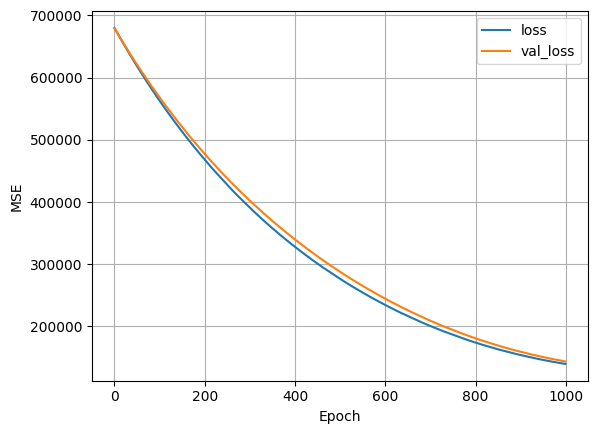

In [ ]:
plot_loss(history_temp)

values are converging

2nd way for finding optimal linear regression (with the help of back propagation):

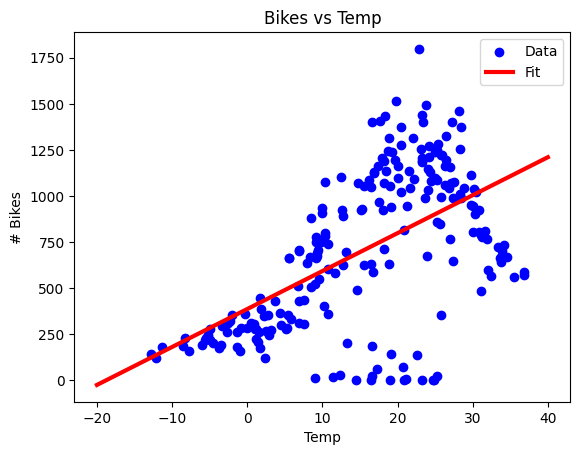

In [ ]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
#plt.plot(x, temp_reg.predict(x), label='Fit', color='red', linewidt=3)                               #! systems expects a 2d array
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('# Bikes')
plt.xlabel('Temp')
plt.show()

# Multiple Regression with Neural Net

In [ ]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(None,len(X_train_all[0])), axis=1)          # axis=None: normalizes whole df
                                                                                                          # =1: normalizes all features
                                                                                                          # =-1: normalizes all datapoints
all_normalizer.adapt(X_train_all)



In [ ]:
all_nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(6)
    ])

In [ ]:
all_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [ ]:
history_all = all_nn_model.fit(
    X_train_all, y_train_all,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_all, y_val_all)
)

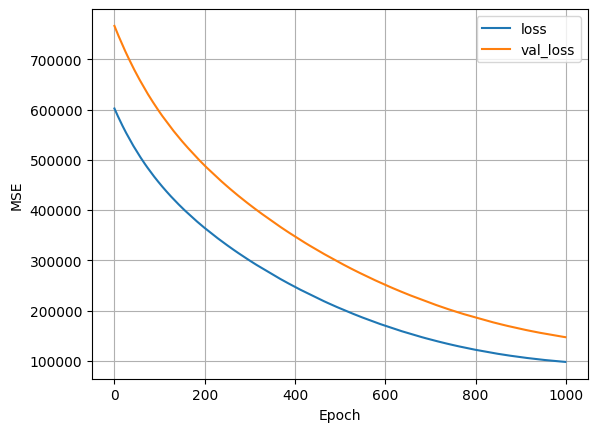

In [ ]:
plot_loss(history_all)

In [ ]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)
print(all_reg.coef_, all_reg.intercept_)

[[ -6.69570711  -9.61519325  23.62125493 143.0641275  -19.43855158
   -5.53650124]] [884.50577243]


In [ ]:
# Create a new LinearRegression model for each feature
regressors = [LinearRegression() for _ in range(X_train_all.shape[1])]          # .shape[1] : returns # of cols
                                                                                  # regressors[0] : 1st instance of the LinReg that has been fitted to the first feature of your data.

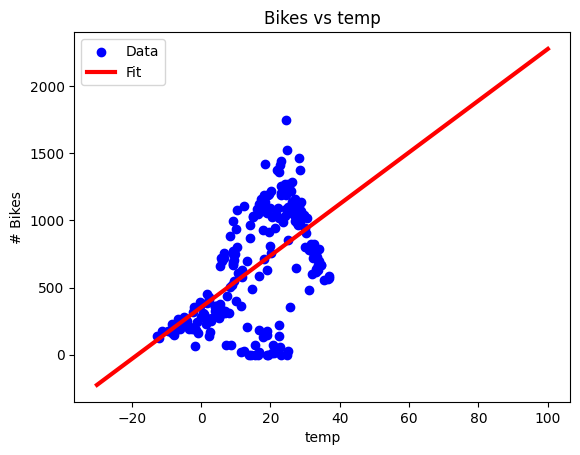

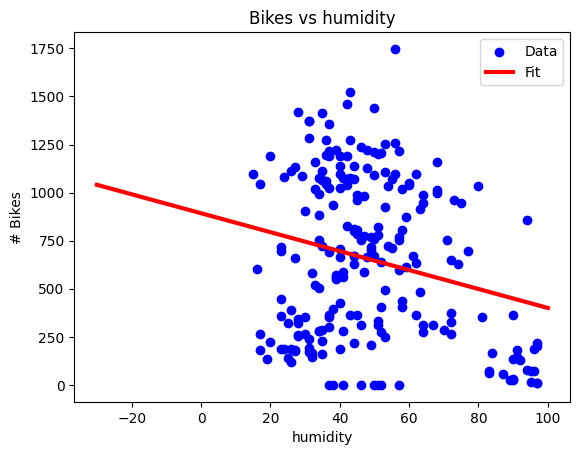

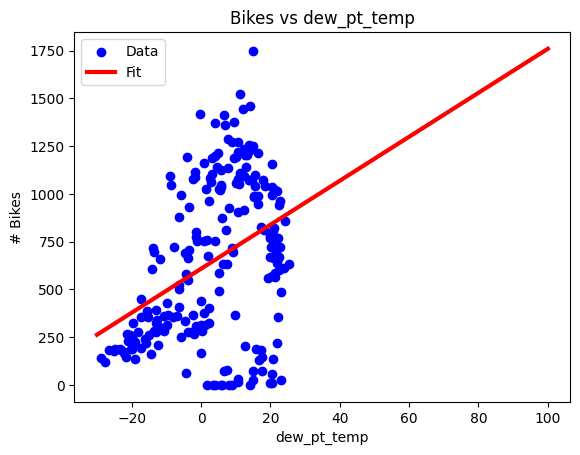

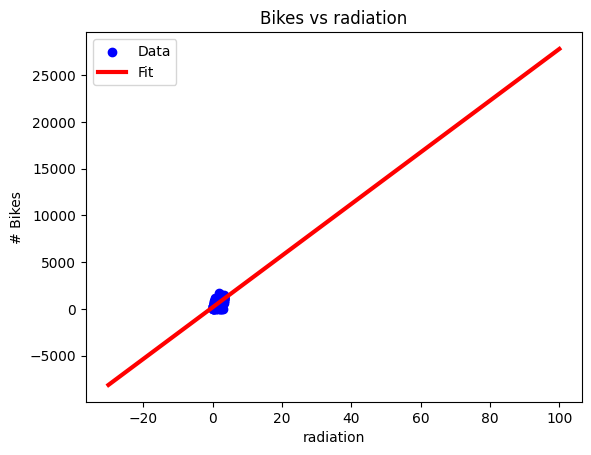

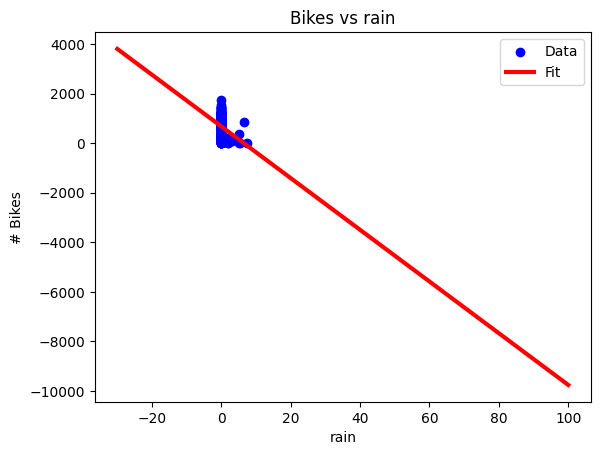

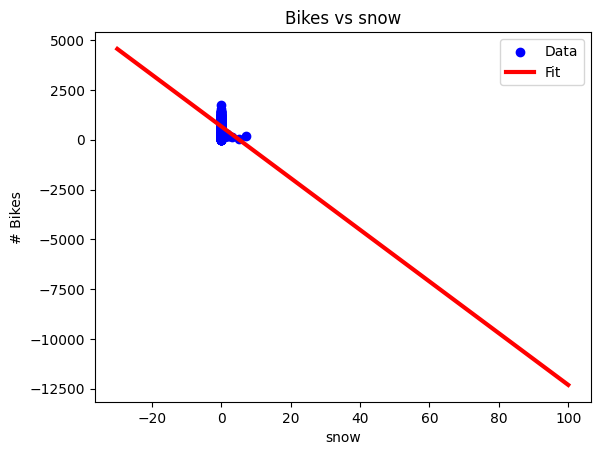

In [ ]:
for n in range(len(X_train_all[0])):
    feature_data = X_train_all[:, n].reshape(-1, 1)
    regressors[n].fit(feature_data, y_train_all)

    plt.scatter(X_train_all[:, n].reshape(-1,1), y_train_all, label='Data', color='blue')
    x = tf.linspace(-30, 100, 250)
    plt.plot(x, regressors[n].predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)
    plt.title(f'Bikes vs {df.columns[n+1]}')
    plt.ylabel('# Bikes')
    plt.xlabel(df.columns[n+1])
    plt.legend()
    plt.show()

# Neural Net

Using whole NN in order to predict the regression

In [ ]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)                                 # Output of 1 possible answer & relu because we never can have less than 0 bikes
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [ ]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_val_temp, y_val_temp),
    verbose=0, epochs=100
)

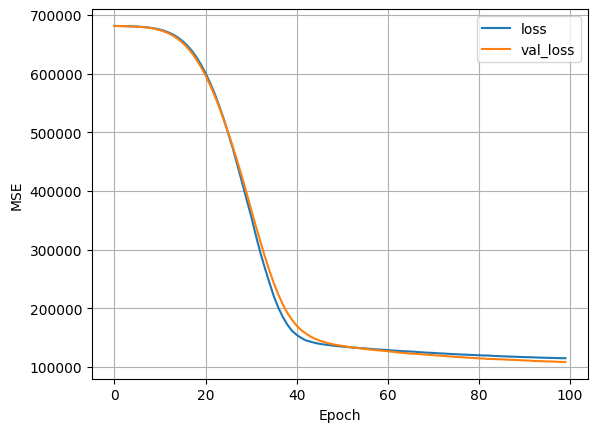

In [ ]:
plot_loss(history)

not optimal -> for ideal have to play further with different parameters

4/4 [==============================] - 0s 3ms/step


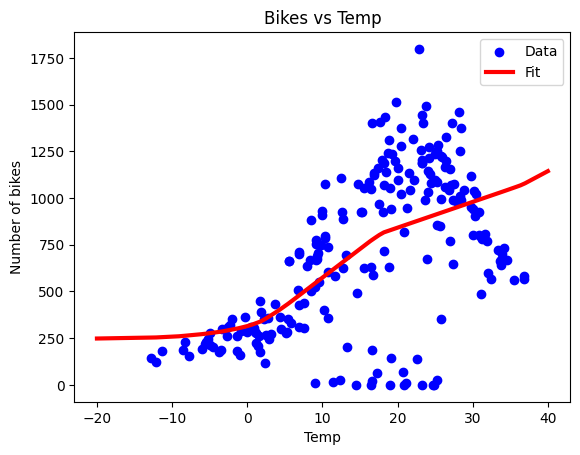

In [ ]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

no longer a linear regression, but we get an estimate for the #bikes

In [ ]:
X_train_all

array([[ 25.9 ,  39.  ,  10.8 ,   2.89,   0.  ,   0.  ],
       [ 33.2 ,  50.  ,  21.3 ,   2.84,   0.  ,   0.  ],
       [  9.1 ,  57.  ,   1.  ,   1.69,   0.  ,   0.  ],
       ...,
       [ -9.6 ,  27.  , -25.1 ,   1.17,   0.  ,   0.  ],
       [ 14.5 ,  57.  ,   6.  ,   1.08,   0.  ,   0.  ],
       [ 26.3 ,  44.  ,  13.  ,   3.24,   0.  ,   0.  ]])

In [ ]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)       # (6,) shape: specifies the type of input dat -> 1D array with 6 features
                                                                                  # axis=-1 : last axis ~ normalizing through the columns
all_normalizer.adapt(X_train_all)

In [ ]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [ ]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data=(X_val_all, y_val_all),
    verbose=0, epochs=100
)

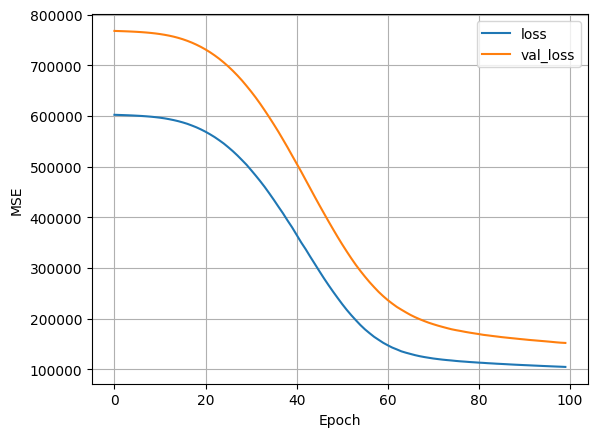

In [ ]:
plot_loss(history)

curve looks interesting, but it's decreasing

R^2 score for Multiple Linear Regression was 0.469 -> isn't applicable for the neural net



In [ ]:
# calculate the MSE for both multi linear reg and nn

y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 [==============================] - 1s 5ms/step


In [ ]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [ ]:
MSE(y_pred_lr, y_test_all)

103389.03687935608

In [ ]:
MSE(y_pred_nn, y_test_all)

137235.69037776216

it appears that the nn has a higher MSE

-> check by ploting the actual results compred to the prediction

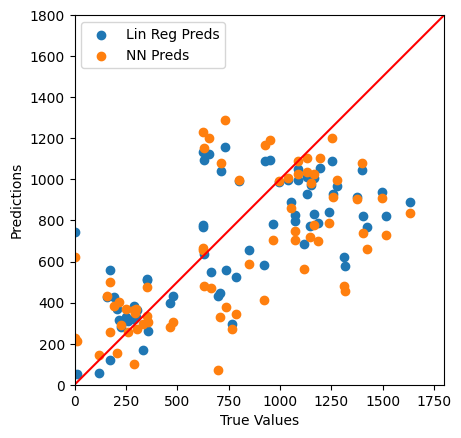

In [ ]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label="NN Preds")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1800]                                                                # defining the different limits for
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")

nn values seem to be more spread out & it tends to understimate the values more, the higher the # bikes

**Therefore sometimes linear regression might be better -> but on the other hand: linear regressort would never see the curve in the 'regression line'**